Loading dataset...
Dataset loaded successfully.
Target distribution:
target
0.0    789400
1.0     10600
Name: count, dtype: int64
Extracting positive and negative samples...
Samples extracted successfully.
Balancing the dataset by upsampling the minority class...
Dataset balanced successfully.
Splitting the dataset into features and target variable...
Dataset split successfully.
Splitting data into training and test sets...
Data split successfully.
Distribution of y_train:
target
1.0    8498
0.0    8462
Name: count, dtype: int64
Defining the XGBoost model...
Defining parameter grid for GridSearchCV...
Starting GridSearchCV to find the best parameters...
Fitting 3 folds for each of 243 candidates, totalling 729 fits
GridSearchCV completed.
Best parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.9}
Training the best model found by GridSearchCV...
Predicting probabilities for unknown users...
Probabilities predicted succe

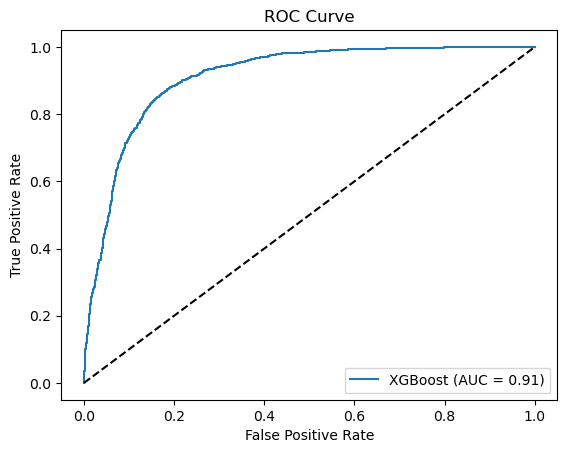

In [6]:
# Install xgboost
!pip install xgboost

import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import time
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

# Record start time
start_time = time.time()

# Step 1: Load the dataset
print("Loading dataset...")
data = pd.read_csv('train.csv')
print("Dataset loaded successfully.")

# Step 2: Check the distribution of the target variable
print("Target distribution:")
print(data['target'].value_counts())

# Step 3: Extract samples where target is 1 and 0
print("Extracting positive and negative samples...")
positive_samples = data[data['target'] == 1]
negative_samples = data[data['target'] == 0]
print("Samples extracted successfully.")

# Step 4: Balance the dataset by upsampling the minority class
print("Balancing the dataset by upsampling the minority class...")
minority_class = positive_samples
majority_class = negative_samples.sample(n=len(positive_samples), replace=True, random_state=42)
balanced_data = pd.concat([majority_class, minority_class])
print("Dataset balanced successfully.")

# Step 5: Split the dataset into features (X) and target (y)
print("Splitting the dataset into features and target variable...")
X = balanced_data.drop(['id', 'target'], axis=1)
y = balanced_data['target']
print("Dataset split successfully.")

# Step 6: Split the data into training and testing sets
print("Splitting data into training and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Data split successfully.")

# Step 7: Check the distribution of y_train
print("Distribution of y_train:")
print(y_train.value_counts())

# Step 8: Define the XGBoost model
print("Defining the XGBoost model...")
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Step 9: Define parameter grid for GridSearchCV
print("Defining parameter grid for GridSearchCV...")
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Step 10: Use GridSearchCV to find the best parameters
print("Starting GridSearchCV to find the best parameters...")
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
print("GridSearchCV completed.")

# Output the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Train the best model found by GridSearchCV
print("Training the best model found by GridSearchCV...")
best_model = grid_search.best_estimator_

# Step 11: Predict probabilities for unknown users
print("Predicting probabilities for unknown users...")
unknown_users = data[data['target'] == 0].drop(['id', 'target'], axis=1)
predicted_probabilities = best_model.predict_proba(unknown_users)[:, 1]
print("Probabilities predicted successfully.")

# Step 12: Determine potential 5G users with a threshold
print("Determining potential 5G users with threshold...")
threshold = 0.5
predicted_labels = (predicted_probabilities > threshold).astype(int)
print("Potential 5G users determined successfully.")

# Step 13: Save the prediction results to an Excel file
print("Saving prediction results to Excel file...")
results = pd.DataFrame({
    'id': data[data['target'] == 0]['id'],
    'predicted_target': predicted_labels
})
results.to_excel('predicted_results_xgboost.xlsx', index=False)
print("Prediction results saved to predicted_results_xgboost.xlsx")

# Step 14: Evaluate the model performance on the test set
print("Evaluating model performance on the test set...")
y_test_pred_prob = best_model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_pred_prob > threshold).astype(int)
print("Classification report for test set:\n", classification_report(y_test, y_test_pred))
auc_score = roc_auc_score(y_test, y_test_pred_prob)
print("AUC score for test set:", auc_score)

# Record end time and calculate total run time
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Total run time: {elapsed_time:.2f} seconds")

# Plot ROC curve
print("Plotting ROC curve...")
fpr, tpr, _ = roc_curve(y_test, y_test_pred_prob)
plt.figure()
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()
